In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import os
import sys

import string
import random


sys.path.append('..')

from utils.io import multi_rle_encode
from tqdm import tqdm_notebook as tqdm

In [50]:
IMAGES_DIR = '../../data/dataset/train_mozaik/images/'
MASKS_DIR = '../../data/dataset/train_mozaik/masks/'

SPLIT_SIZE = 768

SAVE_DIR = '../../data/dataset/train_{}/'.format(SPLIT_SIZE)
SAVE_MASKS = '../../data/dataset/train_{}.csv'.format(SPLIT_SIZE)
os.makedirs(SAVE_DIR, exist_ok=True)

NO_SHIP_BLACK_THRESH = 6 / 9
W_SHIP_BLACK_THRESH = 2 / 9

In [95]:
def random_string(length=10):
    return ''.join([random.choice(string.ascii_letters + string.digits) for n in range(length)])


def save_image(image, image_id):
    path = os.path.join(SAVE_DIR, image_id + '.jpg')
    cv2.imwrite(path, image[..., ::-1])

    
def read_image_and_mask(id):
    
    path1 = os.path.join(IMAGES_DIR, id)
    image= cv2.imread(path1)[..., ::-1]
    
    path2 = os.path.join(MASKS_DIR, id[:-3] + 'png')
    mask = cv2.imread(path2, 0)
    
    return image, mask


def pad(image, divisible_by=128):
    """
    Add additional pixels to image to make it divisible by provided number
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
         (int): size of tiles in pixels, should be 2^n and 
         divisible_by (int): number of pixels
            
    Return:
        image (numpy.ndarray): image with shape divisible by provided number
        paddings (list of tuples): numbers of pixels added on each side
            ((padding_top, padding_bottom), (padding_left, padding_right), (...)) 
        
    """
    h, w = image.shape[:2]

    func = lambda x:(divisible_by - x % divisible_by) / 2
    
    pad_h_top = np.floor(func(h)).astype(np.int_)
    pad_h_bot = np.ceil(func(h)).astype(np.int_)
    pad_w_left = np.floor(func(w)).astype(np.int_)
    pad_w_right = np.ceil(func(w)).astype(np.int_)

    paddings = ((pad_h_top, pad_h_bot), 
                (pad_w_left, pad_w_right), 
                (0,0))

    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)

    image = np.pad(image, paddings, mode='reflect')

    return image
    

def visualize(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask.squeeze())
    
def split(image, mask, size=768):
    for i in range(image.shape[0]//size):
        for j in range(image.shape[1]//size):
            yield (image[i*size:(i+1)*size, j*size:(j+1)*size],
                   mask[i*size:(i+1)*size, j*size:(j+1)*size])
            
def remove_small_ships(rle_masks: list):
    res = []
    for rle_mask in rle_masks:
        x = rle_mask.split(' ')
        if len(x) < 4:
            continue
        x = [int(c) for c in x]
        x = np.array(x)
        x_sum = x[1::2].sum()
        if x_sum <= 4:
            continue
        res.append(rle_mask)
    return res

In [ ]:
out_data = []

for big_image_id in tqdm(os.listdir(IMAGES_DIR)):
# big_image_id = '000006.jpg'
    image, mask = read_image_and_mask(big_image_id)
    image = pad(image, SPLIT_SIZE)
    mask = pad(mask, SPLIT_SIZE)


    for s_image, s_mask in split(image, mask, size=SPLIT_SIZE):


        black_pixels_ratio = (s_image.argmax(axis=-1) == 0).sum() / SPLIT_SIZE**2
        is_empty = (s_mask.sum() == 0)

        if is_empty and black_pixels_ratio > NO_SHIP_BLACK_THRESH:
            continue

        if black_pixels_ratio > W_SHIP_BLACK_THRESH:
            continue

        rle_masks = remove_small_ships(multi_rle_encode(s_mask))
        image_id = random_string(10)

        if rle_masks:
            for rle_mask in rle_masks:
                out_data.append({
                    'ImageId': image_id,
                    'EncodedPixels': rle_mask,
                    'black_rate': black_pixels_ratio,
                    'big_image_id': big_image_id
                })
        else:
            out_data.append({
                'ImageId': image_id,
                'EncodedPixels': None,
                'black_rate': black_pixels_ratio,
                'big_image_id': big_image_id,
            })

        save_image(s_image, image_id)


    #     #print(out_data)

    #     visualize(s_image, s_mask)
    #     plt.show()
    #     print(black_pixels_ratio, is_empty)

    #     if s_mask.sum() > 0:
    #         break

A Jupyter Widget

In [105]:
df = pd.DataFrame(out_data)
#df.to_csv(SAVE_MASKS, index=False)

In [106]:
df

EncodedPixels     ImageId  \
0                                                    None  0s0xVjUc4w   
1                                                    None  lCoHXnbeyF   
2                                                    None  pNNFnPBQmL   
3                                                    None  6cr6xRZyRa   
4                                                    None  VK9iY8pCld   
5                                                    None  TYA8vGN0X0   
6                                                    None  rCR9CoSRpu   
7                                                    None  rFiRWyY2kw   
8                                                    None  Jd6LbtsyZ3   
9                                                    None  PRbjjPug45   
10      559189 17 559957 33 560725 33 561493 33 562261...  pACmHXtDOT   
11      84 33 852 33 1620 33 2388 33 3156 33 3924 33 4...  T4o6KBWbBP   
12                                                   None  qZin4EV8sJ   
13                                        17034 5 17802 5  EDni959LiR   
14      288222 1 288988 3 289754 6 290520 8 291286 11 ...  EDni959LiR   
15      162468 2 163235 4 164004 3 164772 4 165541 3 1...  EDni959LiR   
16      390835 1 391603 2 392370 4 393139 5 393908 5 3...  EDni959LiR   
17      393941 1 394707 4 395474 6 396241 8 397010 8 3...  EDni959LiR   
18      182177 1 182943 4 183710 6 184479 5 185248 5 1...  cHmvnH5RDC   
19      18602 3 19370 3 20138 3 20906 3 21673 3 22441 ...  cHmvnH5RDC   
20      412891 2 413657 4 414424 6 415192 6 415961 6 4...  cHmvnH5RDC   
21      164261 1 165028 4 165796 5 166563 8 167330 10 ...  cHmvnH5RDC   
22      88774 3 89542 9 90309 13 91077 13 91845 13 926...  yeiVEYMeyB   
23                                                   None  qSGKFDwRFm   
24                                                   None  RaGocxHJhL   
25                                                   None  a9NhIi5O6m   
26      211969 2 212737 3 213505 4 214273 6 215041 7 2...  OMwn4Qfjxx   
27                                                   None  7bDhmbz0Uu   
28                                                   None  FaS2yvX9yf   
29      85801 1 86568 3 87335 6 88103 7 88870 9 89637 ...  kFlLXE7gNJ   
...                                                   ...         ...   
182642                                               None  JDAWIgGUpC   
182643                                               None  DenubNtEaV   
182644                                               None  JLHFdg1Meu   
182645                                               None  2mDMisQhdv   
182646                                               None  aU6WTyT47W   
182647                                               None  u5bZx2Yftj   
182648                                               None  3YLFohbUW0   
182649                                               None  o9tgQJzpfK   
182650                                               None  LFfrcFKnOw   
182651                                               None  7Pp1DBzGMx   
182652                                               None  rzEedFYIG6   
182653                                               None  G4DaXBXVNZ   
182654                                               None  TDR1NSwbxZ   
182655                                               None  wV43Bq3vzt   
182656                                               None  LMSg98iKuZ   
182657                                               None  fPaMyerp2c   
182658                                               None  ylRT9y3OP5   
182659                                               None  VpvMznDUQ5   
182660                                               None  hTyP9GvTDa   
182661                                               None  mxKVZwu3A7   
182662                                               None  CfXfU6RaPT   
182663                                               None  5IhQcTZDrt   
182664                                               None  1kAPHLY3sV   
182665                       

In [101]:
len(df.ImageId.unique())

173634

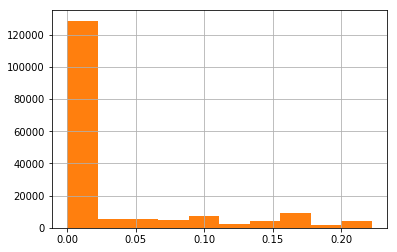

In [104]:
df.drop_duplicates('ImageId').black_rate.hist()
plt.show()